In [ ]:
import json
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from datasets import load_dataset
import nnsight
from nnsight import LanguageModel, CONFIG
import matplotlib.pyplot as plt
import gc
import os
import random

# Model configuration
# model_name = "Qwen/Qwen2.5-7B-Instruct"
model_name = "meta-llama/Llama-3.1-8B-Instruct"
# model_name = "mistralai/Mistral-7B-Instruct-v0.3"
REMOTE = False 

os.environ['HF_HOME'] = '/scratch/ss13750/huggingface'
os.environ['HF_HUB_CACHE'] = '/scratch/ss13750/huggingface'
os.environ['HF_TOKEN'] = ''

def load_model():
    if not REMOTE:
        llm = LanguageModel(model_name, device_map="auto", torch_dtype=torch.bfloat16, cache_dir='/scratch/ss13750/huggingface')
    else:
        llm = LanguageModel(model_name)
    return llm

llm = load_model()
print("Model loaded.")

/scratch/ss13750/conda-envs/nnsight/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# --- 2. Data Loading (Local File) ---
def load_local_arithmetic(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            # Apply the mapping from the HF script to match expected format
            context = (
                obj["context"]
                .strip()
                .replace("\n\n", "\n")
                .replace("Q:", "Question:")
                .replace("A:", "Answer:")
            )
            data.append({"context": context, "completion": obj["completion"]})
    return pd.DataFrame(data)

# I downloaded this file to your notebooks/data directory
df = load_local_arithmetic("/scratch/ss13750/nnsight/notebooks/data/single_digit_three_ops.jsonl")
print(f"Dataset loaded. Length: {len(df)}")

# --- 3. Token Setup ---
def get_digit_tokens(tokenizer):
    digits = "0123456789"
    digit_token_ids = []
    for d in digits:
        ids = tokenizer.encode(d, add_special_tokens=False)
        digit_token_ids.append(ids[-1])
    return torch.tensor(digit_token_ids)

# digit_token_ids = get_digit_tokens(llm.tokenizer).to(llm.device)


In [ ]:
df = df.head(10)

In [9]:
# --- 2. Few-Shot Prompt ---
# This ensures the model knows to just output the number.
FEW_SHOT_PROMPT = """Question: What is (4 * 4) * 1? Answer: 16
Question: What is (8 + 3) * 5? Answer: 55
Question: What is (7 + 5) - 6? Answer: 6\n"""

# --- 3. Token Setup ---
digits = "0123456789"
digit_token_ids = [llm.tokenizer.encode(d, add_special_tokens=False)[-1] for d in digits]

# --- 4. Main Ablation Loop ---
df = load_local_arithmetic("/scratch/ss13750/nnsight/notebooks/data/single_digit_three_ops.jsonl")
sampled_df = df.sample(n=200, random_state=42)

all_logit_changes = []
all_accuracies = []
all_baseline_accuracies = []

for idx, row in tqdm(sampled_df.iterrows(), total=len(sampled_df)):
    context = row['context']
    completion = row['completion'].strip()
    
    if completion.startswith("-"):
        current_input = context + " -"
        target_digit = completion[1]
    else:
        current_input = context + " "
        target_digit = completion[0]
    
    full_prompt = FEW_SHOT_PROMPT + current_input
    target_token_id = llm.tokenizer.encode(target_digit, add_special_tokens=False)[-1]
    
    with torch.no_grad():
        # --- Clean Run (Baseline) ---
        with llm.trace(full_prompt) as tracer:
            output = llm.output.logits.save()
        
        clean_logits = output[0, -1, :].cpu().float()
        
        # log_prob of target digit
        probs = F.softmax(clean_logits, dim=-1)
        baseline_lp = torch.log(probs[target_token_id] + 1e-10).item()
        
        # calculate baseline accuracy
        digit_probs_clean = F.softmax(clean_logits[digit_token_ids].float(), dim=-1)
        clean_pred_id = digit_token_ids[torch.argmax(digit_probs_clean).item()]
        all_baseline_accuracies.append(1 if clean_pred_id == target_token_id else 0)
        
        case_changes = []
        case_accs = []
        
        # --- Ablation ---
        for layer in llm.model.layers:
            with llm.trace(full_prompt) as tracer:
                layer.output = layer.inputs[0][0] 
                abl_output = llm.output.logits.save()
            
            abl_logits = abl_output[0, -1, :].cpu().float()
            
            # Log Prob Change
            abl_probs = F.softmax(abl_logits, dim=-1)
            abl_lp = torch.log(abl_probs[target_token_id] + 1e-10).item()
            case_changes.append(abl_lp - baseline_lp) 
            
            # Ablated Accuracy
            digit_probs_abl = F.softmax(abl_logits[digit_token_ids].float(), dim=-1)
            pred_id = digit_token_ids[torch.argmax(digit_probs_abl).item()]
            case_accs.append(1 if pred_id == target_token_id else 0)
            
        all_logit_changes.append(case_changes)
        all_accuracies.append(case_accs)
        
    if idx % 5 == 0:
        gc.collect()
        torch.cuda.empty_cache()

# --- 5. Calculation of Means ---
avg_logit_changes = np.mean(all_logit_changes, axis=0)
avg_accuracies = np.mean(all_accuracies, axis=0)
avg_baseline_acc = np.mean(all_baseline_accuracies)

100%|██████████| 200/200 [04:14<00:00,  1.27s/it]


In [10]:
avg_accuracies

array([0.25 , 0.245, 0.63 , 0.61 , 0.565, 0.71 , 0.5  , 0.62 , 0.645,
       0.66 , 0.635, 0.615, 0.64 , 0.62 , 0.565, 0.51 , 0.565, 0.515,
       0.625, 0.63 , 0.625, 0.68 , 0.67 , 0.735, 0.64 , 0.605, 0.71 ,
       0.755, 0.695, 0.715, 0.76 , 0.74 ])

In [11]:
avg_baseline_acc

np.float64(0.75)

In [12]:
min(avg_accuracies[1:]) /  avg_baseline_acc

np.float64(0.32666666666666666)

Success! Plot saved to:
  PDF: /scratch/ss13750/nnsight/viz/mistral_dual_axis_arithmetic_ablation.pdf
  PNG: /scratch/ss13750/nnsight/viz/mistral_dual_axis_arithmetic_ablation.png


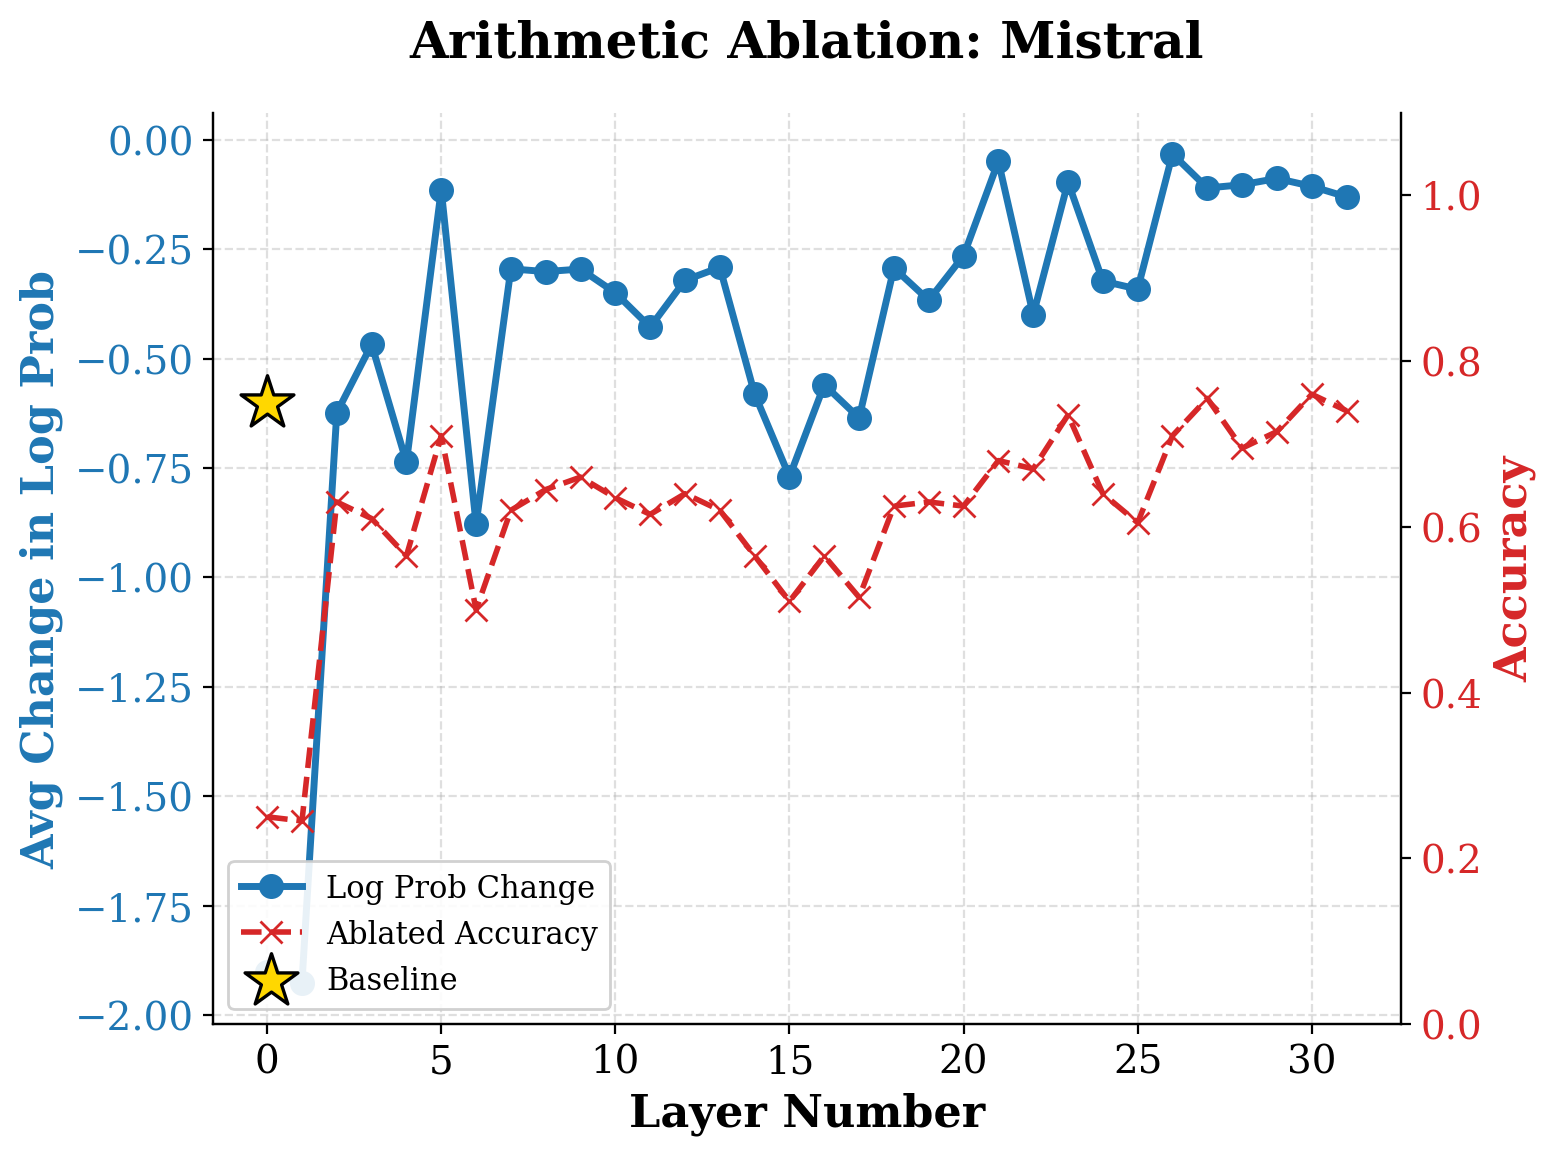

In [13]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- Path Configuration ---
output_dir = "/scratch/ss13750/nnsight/viz"
output_filename = "mistral_dual_axis_arithmetic_ablation.pdf"
save_path = os.path.join(output_dir, output_filename)

# Ensure directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --- Professional Styling ---
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.labelweight": "bold",
    "figure.dpi": 200 # Higher DPI for better quality
})

color_logit = '#1f77b4'
color_acc = '#d62728'
color_star = '#FFD700'

fig, ax1 = plt.subplots(figsize=(8, 6))

# --- X-Axis ---
layers = list(range(len(avg_logit_changes)))
ax1.set_xlabel('Layer Number', fontsize=16)

# --- Left Axis: Logit Change ---
ax1.set_ylabel('Avg Change in Log Prob', color=color_logit, fontsize=16)
ln1 = ax1.plot(layers, avg_logit_changes, color=color_logit, marker='o', 
               linewidth=2.5, markersize=8, label='Log Prob Change', zorder=3)
ax1.tick_params(axis='y', labelcolor=color_logit, labelsize=14)
ax1.grid(True, linestyle='--', alpha=0.4, zorder=1)

# --- Right Axis: Accuracy ---
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color=color_acc, fontsize=16)
ln2 = ax2.plot(layers, avg_accuracies, color=color_acc, linestyle='--', 
               marker='x', linewidth=2, markersize=8, label='Ablated Accuracy', zorder=4)

# Baseline "Star"
star = ax2.scatter([0], [avg_baseline_acc], color=color_star, marker='*', s=400, 
                   label='Baseline', zorder=10, edgecolors='black', linewidths=1.2)

ax2.tick_params(axis='y', labelcolor=color_acc, labelsize=14)
ax2.set_ylim(0, 1.1)

# --- Clean Layout ---
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# --- Combined Legend ---
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='lower left', frameon=True, fontsize=11, framealpha=0.9).set_zorder(20)

plt.title('Arithmetic Ablation: Mistral', fontsize=18, pad=20, fontweight='bold')
fig.tight_layout()

# --- Save Files ---
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.savefig(save_path.replace(".pdf", ".png"), format='png', bbox_inches='tight')

print(f"Success! Plot saved to:\n  PDF: {save_path}\n  PNG: {save_path.replace('.pdf', '.png')}")
plt.show()

In [40]:
import os
import gc
import json
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from nnsight import LanguageModel
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import matplotlib.pyplot as plt

# --- 1. Configuration ---
# Define your models/adapters here
# Format: {"label": "Display Name", "base": "base_model_path", "adapter": "path_to_adapter_or_None"}
models_to_compare = [
    {
        "label": "Qwen Base", 
        "base": "Qwen/Qwen2.5-7B-Instruct", 
        "adapter": None
    },
    {
        "label": "Qwen (Iterative)",
        "base": "/scratch/ss13750/nnsight/out_models/Qwen_Qwen2_5-7B-Instruct__4-5-11-12-17-20-24", 
        "adapter": None
    },
    {
        "label": "Qwen (Iterative + FT)", 
        "base": "/scratch/ss13750/nnsight/out_models/Qwen_Qwen2_5-7B-Instruct__4-5-11-12-17-20-24", 
        "adapter": "/scratch/ss13750/rl/outputs/new7iter_lora_self_dolci_qwen/checkpoint-11250"
    },
    {
        "label": "Llama Base", 
        "base": "meta-llama/Llama-3.1-8B-Instruct", 
        "adapter": None
    },
    {
        "label": "Llama (Cossim)", 
        "base": "/scratch/ss13750/nnsight/out_models/meta-llama_Llama-3_1-8B-Instruct__22-23-24-25-26-27-28-29", 
        "adapter": None
    },
    {
        "label": "Llama (Cossim + FT)", 
        "base": "/scratch/ss13750/nnsight/out_models/meta-llama_Llama-3_1-8B-Instruct__22-23-24-25-26-27-28-29", 
        "adapter": "/scratch/ss13750/rl/outputs/8cossim_lora_self_dolci_llama/checkpoint-11250"
    },
    {
        "label": "Mistral Base", 
        "base": "mistralai/Mistral-7B-Instruct-v0.3", 
        "adapter": None
    },
    {
        "label": "Mistral (BI)", 
        "base": "/scratch/ss13750/nnsight/out_models/mistralai_Mistral-7B-Instruct-v0_3__21-22-23-24-25-26-27-28", 
        "adapter": None
    },
    {
        "label": "Mistral (BI + FT)", 
        "base": "/scratch/ss13750/nnsight/out_models/mistralai_Mistral-7B-Instruct-v0_3__21-22-23-24-25-26-27-28", 
        "adapter": "/scratch/ss13750/rl/outputs/8cossim_lora_self_dolci_mistral/checkpoint-11250"
    },
    
]

FEW_SHOT_PROMPT = """Question: What is (4 * 4) * 1? Answer: 16
Question: What is (8 + 3) * 5? Answer: 55
Question: What is (7 + 5) - 6? Answer: 6\n"""

# --- 2. Adapter Loading Logic ---
def load_nnsight_model(config):
    base_path = config["base"]
    adapter_path = config["adapter"]
    
    print(f"Loading {config['label']}...")
    
    if adapter_path:
        # Load with QLoRA (4-bit) quantization
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_tuple_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True,
        )
        
        # Load Base
        base_model = AutoModelForCausalLM.from_pretrained(
            base_path,
            quantization_config=bnb_config,
            device_map="auto",
            cache_dir='/scratch/ss13750/huggingface'
        )
        # Load Adapter
        model = PeftModel.from_pretrained(base_model, adapter_path)
        tokenizer = AutoTokenizer.from_pretrained(base_path)
        
        # Wrap in NNsight
        return LanguageModel(model, tokenizer=tokenizer)
    else:
        # Standard load for base models
        return LanguageModel(
            base_path, 
            device_map="auto", 
            torch_dtype=torch.bfloat16, 
            cache_dir='/scratch/ss13750/huggingface'
        )

# --- 3. Prep Data ---
def load_local_arithmetic(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            context = obj["context"].strip().replace("\n\n", "\n").replace("Q:", "Question:").replace("A:", "Answer:")
            data.append({"context": context, "completion": obj["completion"]})
    return pd.DataFrame(data)

df = load_local_arithmetic("/scratch/ss13750/nnsight/notebooks/data/single_digit_three_ops.jsonl")
sampled_df = df.sample(n=100, random_state=42)

model_accuracies = {}

# --- 4. Evaluation Loop ---
for config in models_to_compare:
    llm = load_nnsight_model(config)
    llm.tokenizer.pad_token = llm.tokenizer.eos_token
    
    digits = "0123456789"
    digit_token_ids = [llm.tokenizer.encode(d, add_special_tokens=False)[-1] for d in digits]
    
    correct = 0
    
    for idx, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc=f"Testing {config['label']}"):
        completion = row['completion'].strip()
        current_input = row['context'] + (" -" if completion.startswith("-") else " ")
        target_digit = completion[1] if completion.startswith("-") else completion[0]
        
        full_prompt = FEW_SHOT_PROMPT + current_input
        target_token_id = llm.tokenizer.encode(target_digit, add_special_tokens=False)[-1]
        
        with torch.no_grad():
            with llm.trace(full_prompt) as tracer:
                output = llm.output.logits.save()
            
            logits = output[0, -1, :].cpu().float()
            digit_logits = logits[digit_token_ids]
            if digit_token_ids[torch.argmax(digit_logits).item()] == target_token_id:
                correct += 1
                
    acc = correct / len(sampled_df)
    model_accuracies[config["label"]] = acc
    print(f"Result: {acc:.1%}")
    
    # Clean Memory
    del llm
    gc.collect()
    torch.cuda.empty_cache()

Loading Qwen Base...


Testing Qwen Base: 100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


Result: 96.0%
Loading Qwen (Iterative)...


Testing Qwen (Iterative): 100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


Result: 37.0%
Loading Qwen (Iterative + FT)...


Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]
/scratch/ss13750/conda-envs/nnsight/lib/python3.10/site-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['alora_invocation_tokens', 'arrow_config', 'ensure_weight_tying', 'peft_version'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(
Testing Qwen (Iterative + FT): 100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


Result: 74.0%
Loading Llama Base...


Testing Llama Base: 100%|██████████| 100/100 [00:10<00:00,  9.62it/s]


Result: 60.0%
Loading Llama (Cossim)...


Testing Llama (Cossim): 100%|██████████| 100/100 [00:08<00:00, 11.51it/s]


Result: 38.0%
Loading Llama (Cossim + FT)...


Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]
/scratch/ss13750/conda-envs/nnsight/lib/python3.10/site-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['alora_invocation_tokens', 'arrow_config', 'ensure_weight_tying', 'peft_version'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(
Testing Llama (Cossim + FT): 100%|██████████| 100/100 [00:12<00:00,  7.99it/s]


Result: 50.0%
Loading Mistral Base...


Testing Mistral Base: 100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


Result: 76.0%
Loading Mistral (BI)...


Testing Mistral (BI): 100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


Result: 28.0%
Loading Mistral (BI + FT)...


Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]
/scratch/ss13750/conda-envs/nnsight/lib/python3.10/site-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['alora_invocation_tokens', 'arrow_config', 'ensure_weight_tying', 'peft_version'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(
Testing Mistral (BI + FT): 100%|██████████| 100/100 [00:12<00:00,  7.93it/s]


Result: 50.0%


In [41]:
model_accuracies

{'Qwen Base': 0.96,
 'Qwen (Iterative)': 0.37,
 'Qwen (Iterative + FT)': 0.74,
 'Llama Base': 0.6,
 'Llama (Cossim)': 0.38,
 'Llama (Cossim + FT)': 0.5,
 'Mistral Base': 0.76,
 'Mistral (BI)': 0.28,
 'Mistral (BI + FT)': 0.5}

In [42]:
results = {}
for key in model_accuracies.keys():
    model = key.split(" ")[0]
    if model not in results.keys():
        results[model] = []
        
    results[model].append(model_accuracies[key])

In [43]:
# results['Mistral'] = [0.76,0.28,0.5]

In [2]:
results={'Qwen': [0.96, 0.37, 0.74],
 'Llama': [0.6, 0.38, 0.5],
 'Mistral': [0.76, 0.28, 0.5]}

Minimal trend plot saved to: /scratch/ss13750/nnsight/viz/arithmetic_average_trend.pdf


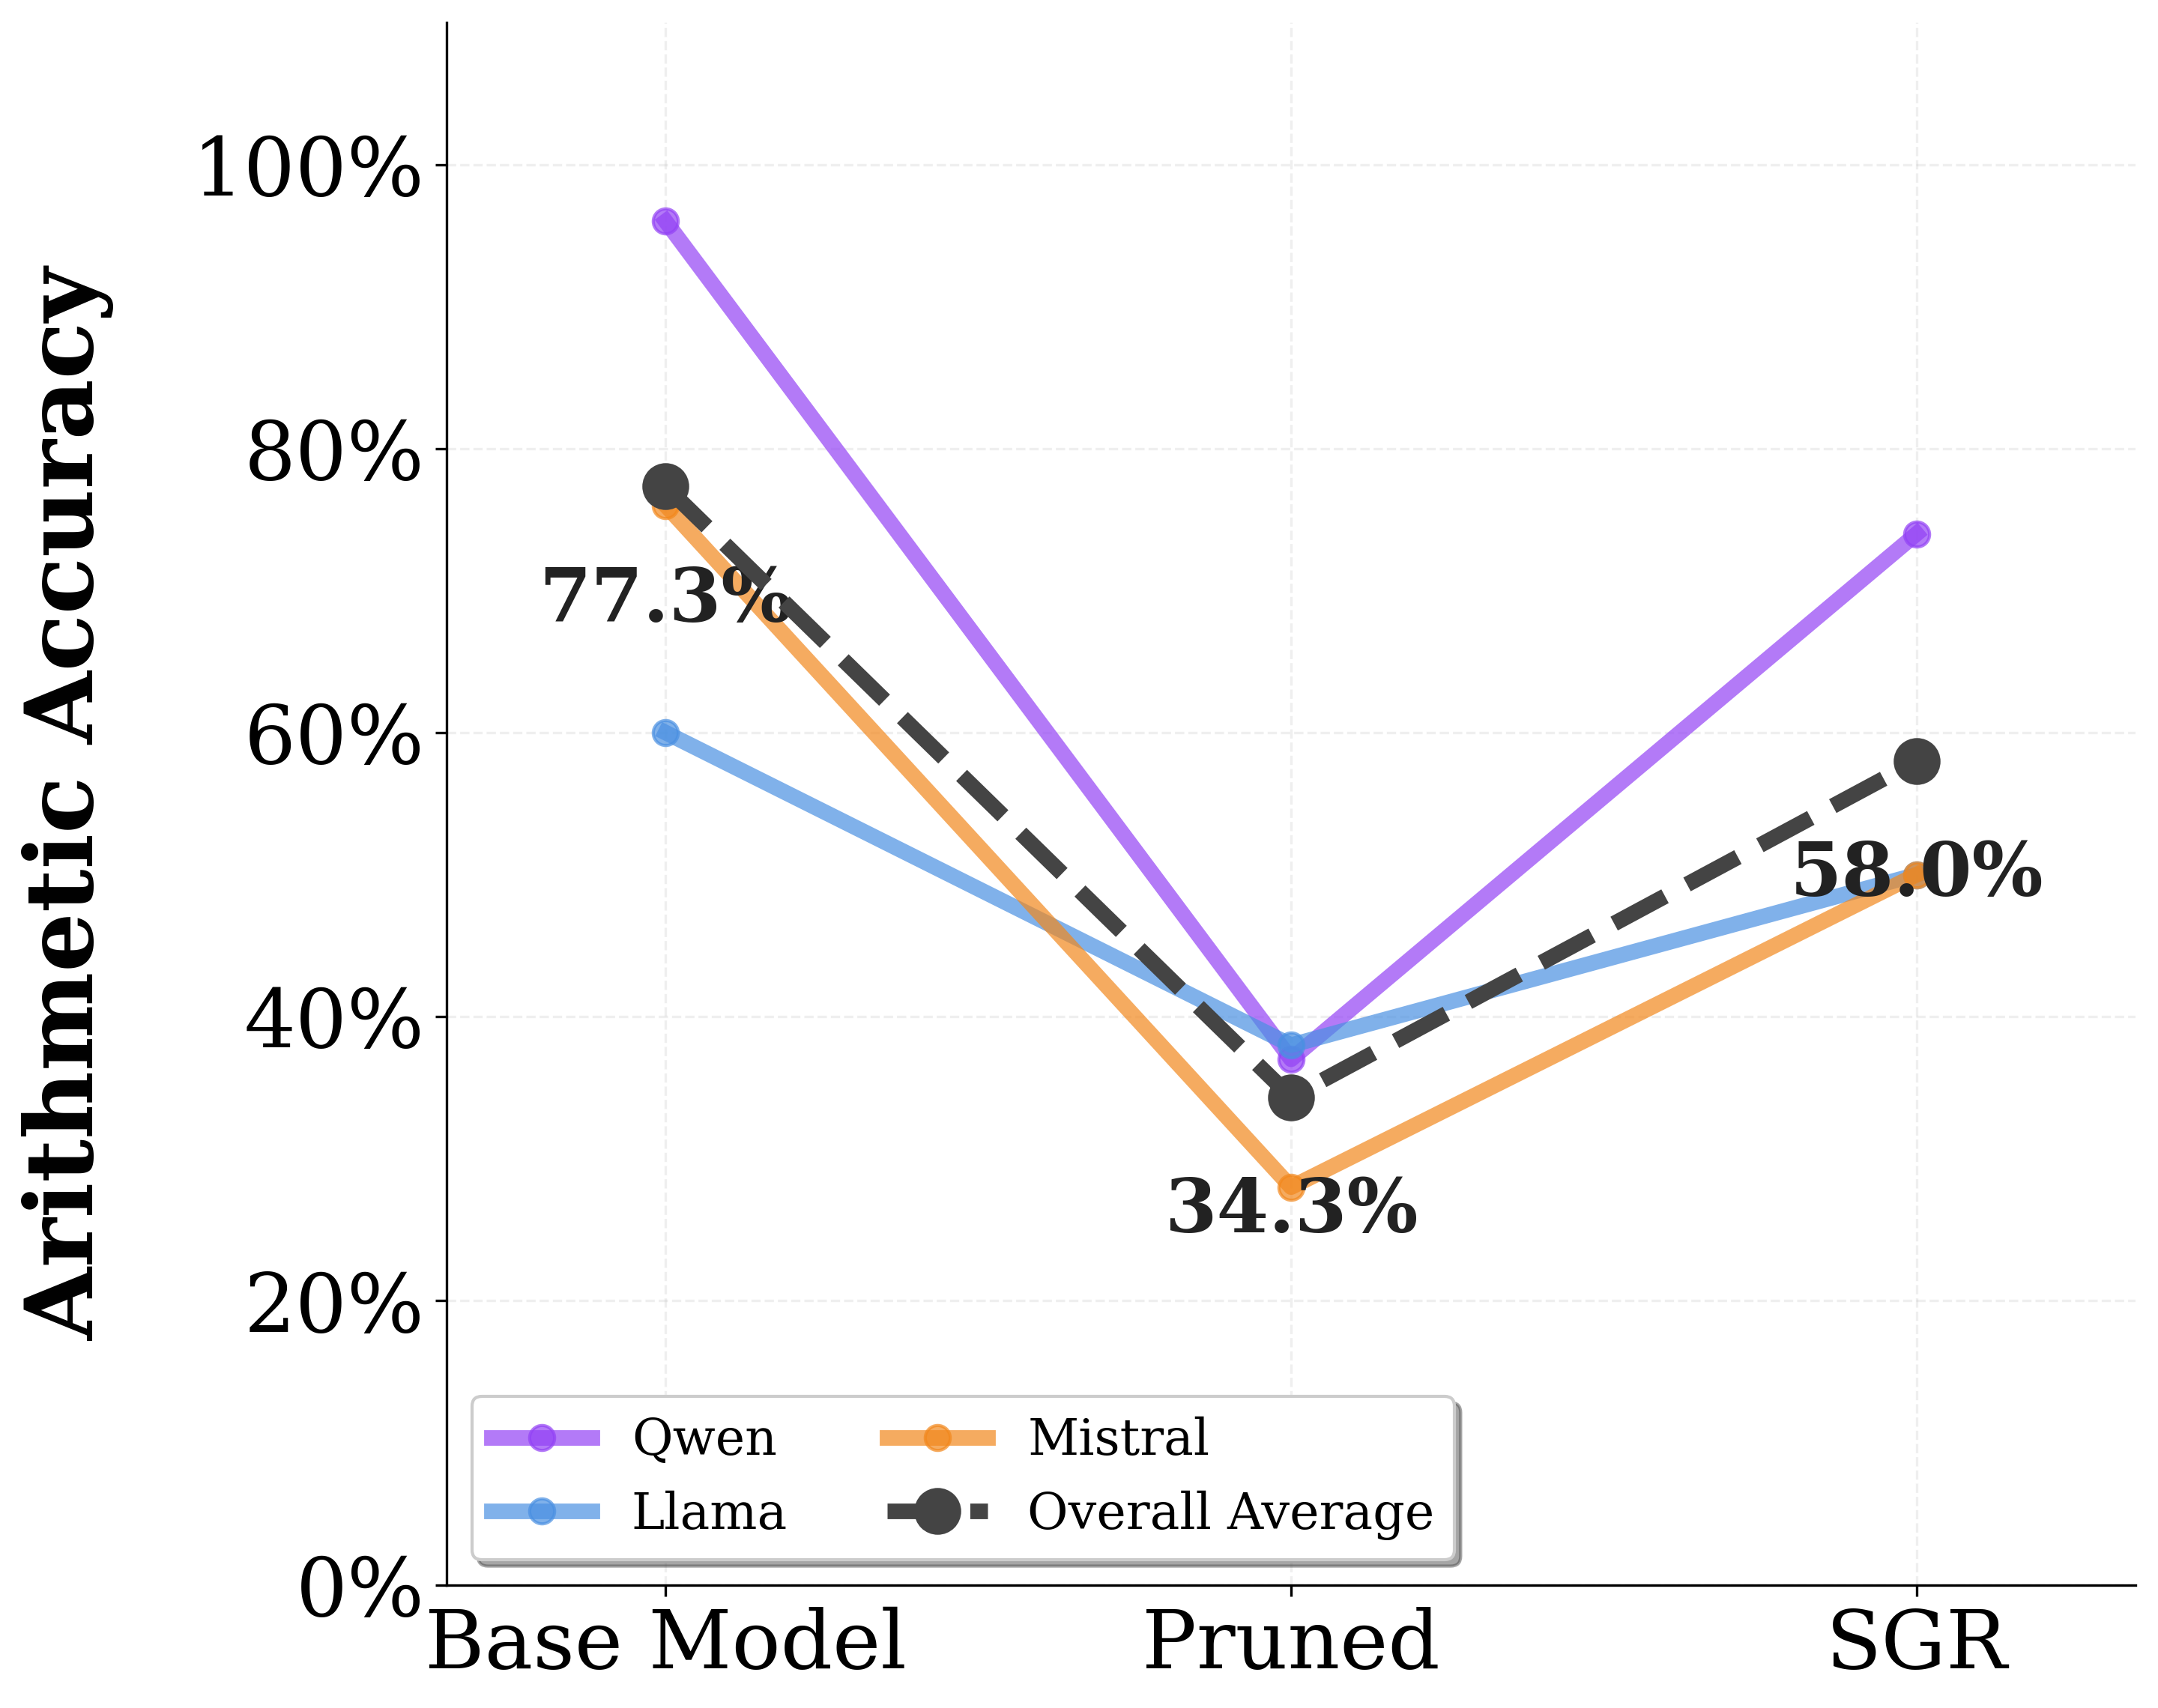

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# --- 1. Data Configuration ---
# Example data mirroring your results
# results = {
#     'Qwen': [0.854, 0.452, 0.821],   
#     'Llama': [0.881, 0.403, 0.785],
#     'Mistral': [0.825, 0.358, 0.752]
# }

model_colors = {
    'Qwen': '#9342f5', 
    'Llama': '#4A90E2',
    'Mistral': '#f2881d'
}

stages = ['Base Model', 'Pruned', 'SGR']

# Calculate the mean performance across models
all_vals = np.array(list(results.values()))
avg_scores = np.mean(all_vals, axis=0) 

# --- 2. Professional Styling ---
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 20,             # Larger font for one-column visibility
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "figure.dpi": 300 
})

fig, ax = plt.subplots(figsize=(10, 8))

# --- 3. Plot Individual Lines (Faded) ---
for model, scores in results.items():
    ax.plot(stages, scores, marker='o', markersize=8, linewidth=5, 
            color=model_colors[model], zorder=2, alpha=0.7, label=model) # Very faded

# --- 4. Plot Average Line (Subtle but Clear) ---
ax.plot(stages, avg_scores, marker='o', markersize=14, linewidth=5, 
        color='#444444', zorder=5, linestyle="dashed", label='Overall Average')

# Annotate numbers below each point on the average line
for i, avg_val in enumerate(avg_scores):
    ax.annotate(
        f'{avg_val:.1%}', 
        (stages[i], avg_val),
        textcoords="offset points", 
        xytext=(0, -25), # Positioned below the point
        ha='center', 
        va='top',
        fontweight='black', 
        fontsize=24, 
        color='#222222'
        # No background box as requested
    )

# --- 5. Final Formatting ---
ax.set_ylabel('Arithmetic Accuracy', fontsize=30, labelpad=25)
# ax.set_xlabel('Model Iteration', fontsize=30, labelpad=25)
ax.set_ylim(0, 1.1)

# Large, readable ticks
ax.tick_params(axis='both', which='major', labelsize=26)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Visual cleanup
ax.grid(True, linestyle='--', alpha=0.2, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.title('Arithmetic: Mean Performance Trend', fontsize=34, pad=50)
plt.legend(frameon=True, loc='lower left', fontsize=16, framealpha=1.0, shadow=True, ncol=2)
plt.xlim(-0.35, 2.35) 
plt.tight_layout()

# --- 6. Export ---
output_dir = "/scratch/ss13750/nnsight/viz"
if not os.path.exists(output_dir): os.makedirs(output_dir)
save_path = os.path.join(output_dir, "arithmetic_average_trend.pdf")

plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.savefig(save_path.replace(".pdf", ".png"), format='png', bbox_inches='tight')

print(f"Minimal trend plot saved to: {save_path}")
plt.show()